In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\dldus\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dldus\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dldus\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dldus\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
df = pd.read_csv("data_daegu.csv")
df.head()

,date,confirmed,death,released,weather_temp,weather_rain,social_keyword_corona,social_keyword_disinfection,social_keyword_mask,social_keyword_infection,social_keyword_briefing,date_red,confirmed_foreign,PM10
0,20200301,469,1,2,9.4,0.0,288841,19264,105352,17744,3281,1,0,33
1,20200302,376,4,0,7.1,0.0,341923,32023,202509,17089,3581,0,0,37
2,20200303,520,6,2,7.7,0.0,315235,30640,203550,19368,3270,0,0,23
3,20200304,405,4,0,5.9,0.0,300534,32469,174302,28207,4067,0,0,29
4,20200305,321,3,8,3.7,0.0,278765,26606,161861,26839,3288,0,0,37


In [3]:
from sklearn.model_selection import train_test_split

In [85]:
x = df[['death', 'released', 'weather_temp', 'weather_rain', 'social_keyword_corona', 'social_keyword_disinfection', 'social_keyword_mask', 'social_keyword_infection', 'social_keyword_briefing', 'date_red', 'confirmed_foreign', 'PM10' ]]
y = df[['confirmed']]

x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.9, test_size=0.1)

In [86]:
#### Normalize
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

In [107]:
X = tf.placeholder(tf.float32, shape=[None, 12])
Y = tf.placeholder(tf.float32, shape=[None, 1])

W1 = tf.Variable(tf.random_normal(shape=[12, 16]))
b1 = tf.Variable(tf.random_normal(shape=[16]))
L1 = tf.nn.sigmoid(tf.add(tf.matmul(X, W1), b1))

W2 = tf.Variable(tf.random_normal(shape=[16, 64]))
b2 = tf.Variable(tf.random_normal(shape=[64]))
L2 = tf.nn.tanh(tf.add(tf.matmul(L1, W2), b2))
 
W3 = tf.Variable(tf.random_normal(shape=[64, 32]))
b3 = tf.Variable(tf.random_normal(shape=[32]))
L3 = tf.nn.tanh(tf.add(tf.matmul(L2, W3), b3))

W4 = tf.Variable(tf.random_normal(shape=[32, 1]))
b4 = tf.Variable(tf.random_normal(shape=[1]))

model = tf.add(tf.matmul(L3, W4), b4)

In [108]:
cost=tf.reduce_mean(tf.square(Y-model))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(cost)

In [109]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
loss_save = []

epochs=150
for step in range(epochs):
    sess.run(train_op, feed_dict={X: x_train, Y: y_train})
        
    ###적절한 epoch를 선정하기 위해 각 epoch당 loss를 저장
    #test데이터를 이용해 loss 도출
    #loss_train=sess.run(cost, feed_dict={X: x_train, Y: y_train})
    loss_test=sess.run(cost, feed_dict={X: x_test, Y: y_test})
    #각 epoch당 loss값을 loss_save에 저장
    loss_save.append(loss_test)

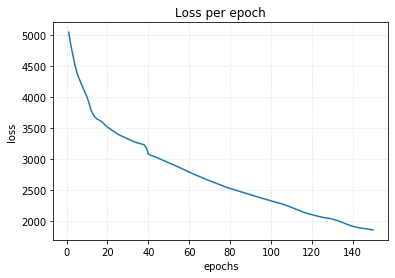

In [111]:
#epoch당 loss 그래프
epoch=np.linspace(1,150,150)
fig = plt.figure()
plt.plot(epoch,loss_save)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss per epoch')
plt.grid(linestyle='--', color='lavender')
plt.show()

In [112]:
##########모델 검증

#최종loss
loss_value_train = sess.run(cost, feed_dict={X: x_train, Y: y_train})
loss_value_test = sess.run(cost, feed_dict={X: x_test, Y: y_test})     
print('epoch: {}/{}, train loss: {:.4f}, test loss: {:.4f}'.format(step+1, epochs, loss_value_train, loss_value_test))

#최종accuracy
accuracy = tf.reduce_mean(tf.cast(model, "float"))
train_accuracy = accuracy.eval(session = sess, feed_dict={X: x_train, Y: y_train})
test_accuracy = accuracy.eval(session = sess, feed_dict={X: x_test, Y: y_test})
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


epoch: 150/150, train loss: 11327.3369, test loss: 1859.8389
Train Accuracy: 18.89435
Test Accuracy: 23.105095


In [113]:
####모델 예측
y_predict = sess.run(model, feed_dict={X:x_test})

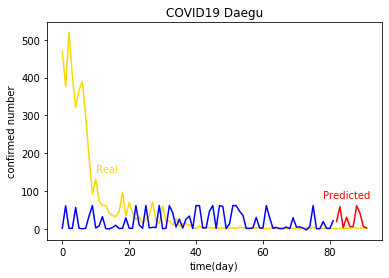

In [120]:
#예측된 값과 실제 값 비교 그래프
t=[82,83,84,85,86,87,88,89,90,91]

plt.title('COVID19 Daegu')
plt.xlabel('time(day)')
plt.ylabel('confirmed number')

plt.text(10,150,'Real',color='gold')
plt.text(78,80,'Predicted',color='red')

y_predict_total = sess.run(model, feed_dict={X:x_train})
plt.plot(y,'gold',y_predict_total,'b',t,y_predict,'r')